# Implementación del Método de Welch para Estimación Espectral

El método de Welch es una técnica para estimar la densidad espectral de potencia (PSD) de una señal. Este método reduce el ruido en los espectros de potencia estimados dividiendo la señal en segmentos superpuestos, aplicando una ventana a cada segmento y promediando los periodogramas modificados resultantes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Generación de una Señal de Ejemplo

Para demostrar el método, primero generaremos una señal de prueba que consiste en dos componentes sinusoidales con ruido gaussiano.

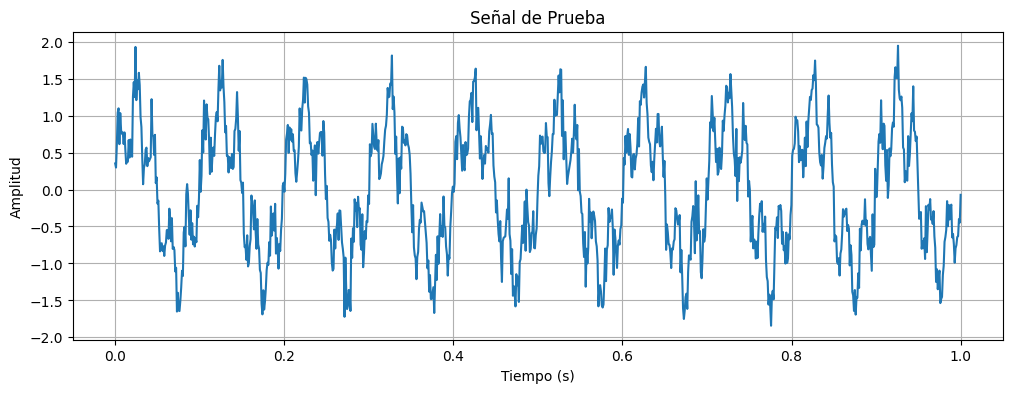

In [7]:
# Generamos una señal de ejemplo
np.random.seed(0)
t = np.linspace(0, 1, 1000)
f1, f2 = 10, 50  # Frecuencias de 10 Hz y 50 Hz
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.random.randn(len(t))

# Visualizamos la señal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.grid(True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal de Prueba')
plt.show()


## 2. División en Segmentos

Dividiremos la señal en segmentos superpuestos. La superposición ayuda a reducir la varianza en la estimación final.
El tamaño del segmento y la superposición son parámetros importantes:
- Segmentos más largos proporcionan mejor resolución frecuencial
- Mayor superposición reduce la varianza pero aumenta el costo computacional

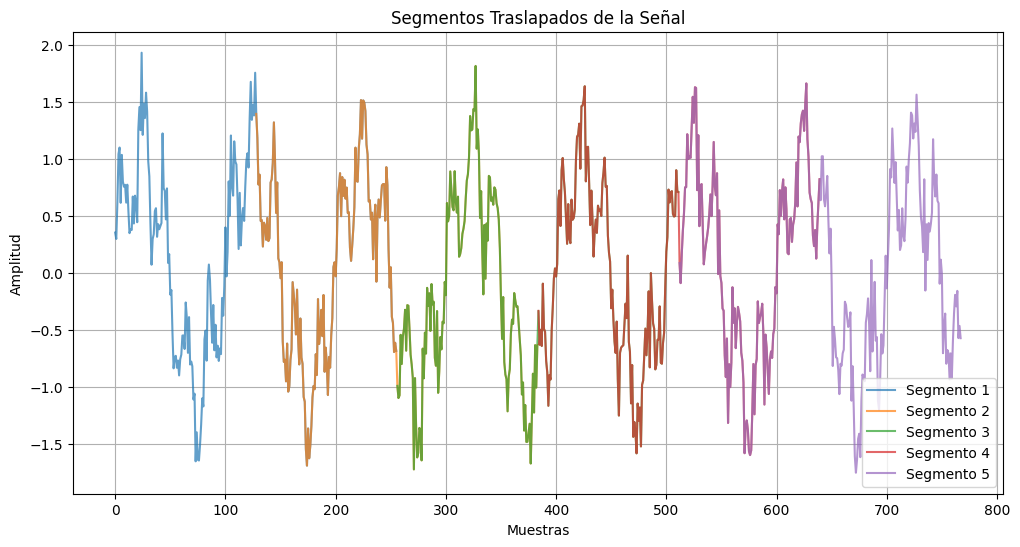

In [17]:
def segment_signal(signal, segment_length, overlap):
	step = segment_length - overlap
	segments = []
	for i in range(0, len(signal) - segment_length + 1, step):
		segments.append(signal[i:i + segment_length])
	return np.array(segments)


# Parámetros para la segmentación
segment_length = 256
overlap = segment_length // 2

# Dividimos la señal en segmentos
segments = segment_signal(signal, segment_length, overlap)

# Visualización de los segmentos traslapados
plt.figure(figsize=(12, 6))
t_segment = np.arange(segment_length)
for i in range(min(5, len(segments))):
	plt.plot(t_segment + i * (segment_length - overlap), segments[i],
			 label=f'Segmento {i + 1}', alpha=0.7)
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Segmentos Traslapados de la Señal')
plt.legend()
plt.show()


## 3. Aplicación de la Ventana

Utilizaremos una ventana de Hanning, que es una elección común porque:
- Tiene buenas propiedades de resolución espectral
- Reduce el fenómeno de fuga espectral (spectral leakage)
- Proporciona un buen balance entre resolución y supresión de lóbulos laterales

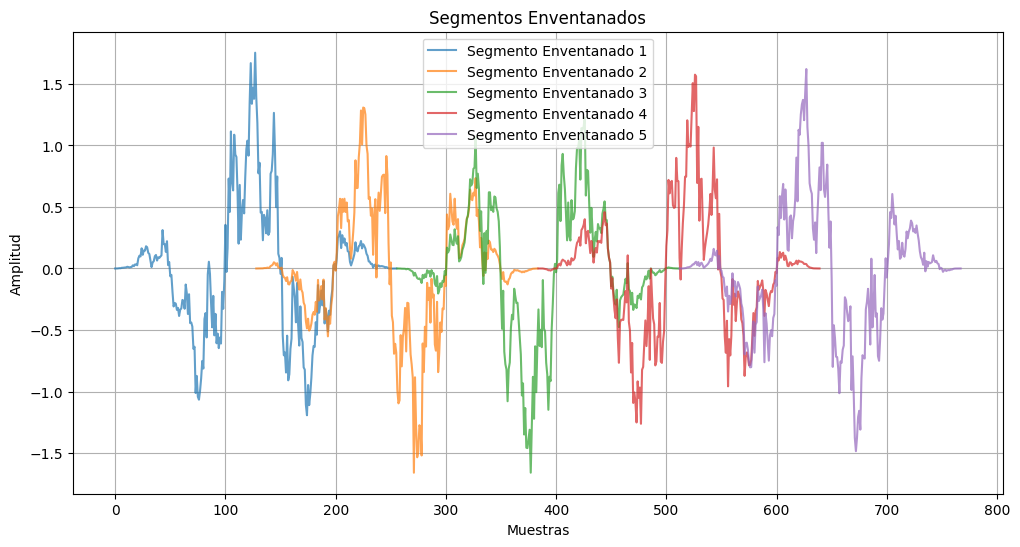

In [18]:
# Creamos y aplicamos la ventana de Hanning
window = np.hanning(segment_length)
windowed_segments = segments * window[None, :]

# Visualizamos los segmentos enventanados
plt.figure(figsize=(12, 6))
t_segment = np.arange(segment_length)
for i in range(min(5, len(windowed_segments))):
	plt.plot(t_segment + i * (segment_length - overlap), windowed_segments[i],
			 label=f'Segmento Enventanado {i + 1}', alpha=0.7)
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Segmentos Enventanados')
plt.legend()
plt.show()


## 4. Cálculo del Espectro mediante FFT

Para cada segmento con ventana, calculamos su FFT y luego el periodograma modificado.

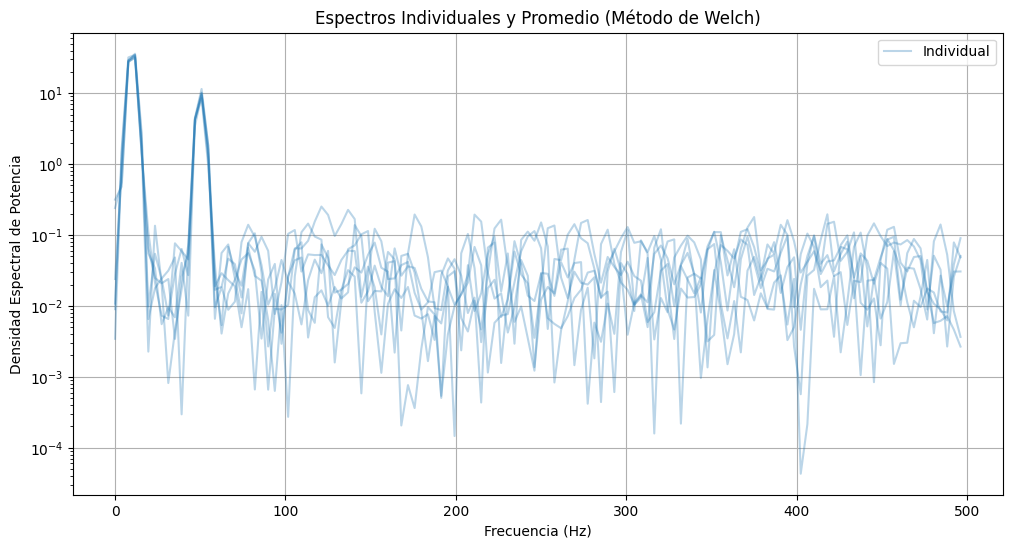

In [25]:
# Obtenemos los índices válidos de frecuencia (hasta Nyquist)
valid_freq_idx = segment_length // 2

# Visualizamos todos los espectros individuales y el promedio
plt.figure(figsize=(12, 6))

# Graficamos los espectros individuales
for i in range(len(periodograms)):
	plt.semilogy(freqs[:valid_freq_idx], periodograms[i, :valid_freq_idx],
				 alpha=0.3, color='C0', label='Individual' if i == 0 else "")

plt.grid(True)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral de Potencia')
plt.title('Espectros Individuales y Promedio (Método de Welch)')
plt.legend()
plt.show()


## 5. Promedio de Espectros

Finalmente, promediamos los periodogramas de todos los segmentos para obtener la estimación final de la PSD.

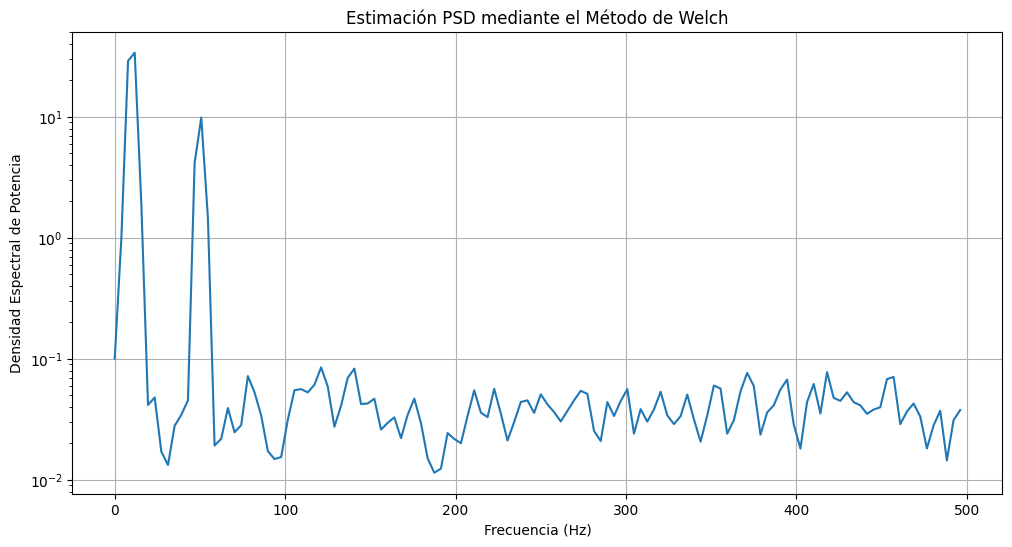

In [26]:
# Calculamos el promedio de los periodogramas
psd_estimate = np.mean(periodograms, axis=0)

# Nos quedamos solo con las frecuencias positivas
positive_freqs = freqs[:segment_length // 2]
psd_positive = psd_estimate[:segment_length // 2]

# Visualizamos el resultado
plt.figure(figsize=(12, 6))
plt.semilogy(positive_freqs, psd_positive)
plt.grid(True)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral de Potencia')
plt.title('Estimación PSD mediante el Método de Welch')
plt.show()

La gráfica resultante muestra claramente los dos picos correspondientes a las frecuencias de 10 Hz y 50 Hz que incluimos en nuestra señal de prueba. El método de Welch ha proporcionado una estimación suavizada del espectro de potencia, reduciendo la varianza en comparación con un único periodograma.


## FFT Clásico
A continuación se muestra el análisis espectral usando la Transformada Rápida de Fourier (FFT) clásica, sin segmentación ni promediado.

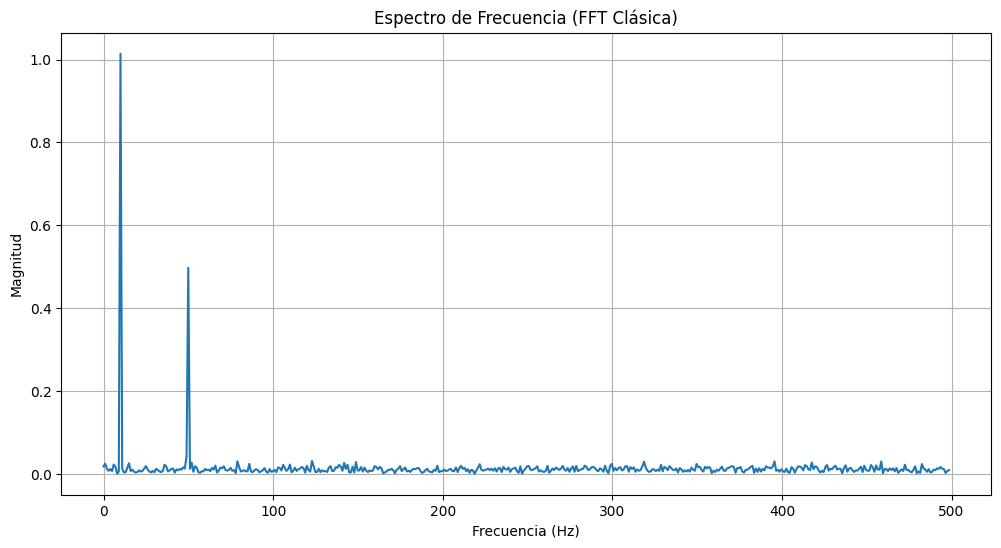

In [27]:
# Calculamos la FFT de la señal completa
fft_result = np.fft.fft(signal)
n = len(signal)
freq = np.fft.fftfreq(n, t[1] - t[0])  # Frecuencias correspondientes

# Solo tomamos la mitad del espectro (frecuencias positivas)
positive_freq = freq[:n // 2]
fft_magnitude = 2.0 / n * np.abs(fft_result[:n // 2])

# Visualizamos el espectro
plt.figure(figsize=(12, 6))
plt.plot(positive_freq, fft_magnitude)
plt.grid(True)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de Frecuencia (FFT Clásica)')
plt.show()

En esta visualización se puede observar:
1. Los dos picos principales en 10Hz y 50Hz correspondientes a las frecuencias de la señal original
2. Mayor variabilidad en el espectro comparado con el método de Welch, ya que no hay promediado
3. La resolución frecuencial es mayor porque usamos toda la señal en un solo cálculo
